In [1]:
# import pickle
from my_util import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import time, pickle, math, warnings, os, operator
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')

from lime.lime_tabular import LimeTabularExplainer
import dill

import matplotlib.pyplot as plt

data_path = './data/'
model_path = './final_model/'

projects = ['openstack','qt']

remove_python_common_tokens = True

    
top_k_tokens = np.arange(10,201,10)
agg_methods = ['avg','median','sum']
max_str_len_list = 100

# since we don't want to use commit metrics in LIME
commit_metrics = ['la','la','ld', 'ld', 'nf','nd_y', 'nd', 'ns','ent', 'ent', 'nrev', 'rtime', 'hcmt', 'self', 'ndev',
                          'age', 'age', 'nuc', 'app_y', 'aexp', 'rexp', 'arexp', 'rrexp', 'asexp', 'rsexp', 'asawr', 'rsawr']

line_score_df_col_name = ['total_tokens', 'line_level_label'] + ['token'+str(i) for i in range(1,max_str_len_list+1)] + [agg+'-top-'+str(k)+'-tokens' for agg in agg_methods for k in top_k_tokens] + [agg+'-all-tokens' for agg in agg_methods]
    
create_path_if_not_exist('./text_metric_line_eval_result/')
create_path_if_not_exist('./final_model/')
create_path_if_not_exist('./data/line-level_ranking_result/')

## Steps for line-level

1. load prediction result, line-level dataset, train/test data
2. load RF model
3. resampling dataset (like in commit-level experiment)
4. train LIME model
5. get correctly predicted result
6. for each correctly predicted result
    - get explanation from LIME
    - get line score (mean, median, sum)
    - put commit_id, code line, line score, label to dataframe
7. combine result in 6. as a single dataframe

note: no need to use differential evolution algorithm to find the best k_neighbors since it is known from training phase

## Get line score from LIME

In [2]:
def get_combined_features(code_commit, commit_id, label, metrics_df, count_vect, mode = 'train'):
    
    if mode not in ['train','test']:
        print('wrong mode')
        return
    
    code_df = pd.DataFrame()
    code_df['commit_id'] = commit_id
    code_df['code'] = code_commit
    code_df['label'] = label
    
    code_df = code_df.sort_values(by='commit_id')
    
    metrics_df = metrics_df.sort_values(by='commit_id')
    
    code_change_arr = count_vect.transform(code_df['code']).astype(np.int16).toarray()
    
    if mode == 'train':
        metrics_df = metrics_df.drop('commit_id',axis=1)
        metrics_df_arr = metrics_df.to_numpy(dtype=np.float32)
        final_features = np.concatenate((code_change_arr,metrics_df_arr),axis=1)
        col_names = list(count_vect.get_feature_names())+list(metrics_df.columns)
        return final_features, col_names, list(code_df['label'])
    elif mode == 'test':
        code_features = pd.DataFrame(code_change_arr, columns=count_vect.get_feature_names())
        code_features['commit_id'] = list(code_df['commit_id'])

        metrics_df = metrics_df.set_index('commit_id')
        code_features = code_features.set_index('commit_id')
        final_features = pd.concat([code_features, metrics_df],axis=1)
        
        return final_features, list(code_df['commit_id']), list(code_df['label'])

def get_LIME_explainer(proj_name, train_feature, feature_names):
    LIME_explainer_path = './final_model/'+proj_name+'_LIME_RF_DE_SMOTE_min_df_3.pkl'
    class_names = ['not defective', 'defective'] # this is fine...
    if not os.path.exists(LIME_explainer_path):
        start = time.time()
        # get features in train_df here
        print('start training LIME explainer')

        explainer = LimeTabularExplainer(train_feature, 
                                         feature_names=feature_names, 
                                         class_names=class_names, discretize_continuous=False, random_state=42)
        dill.dump(explainer, open(LIME_explainer_path, 'wb'))
        print('finish training LIME explainer in',time.time()-start, 'secs')

    else:
        explainer = dill.load(open(LIME_explainer_path, 'rb'))
    
    return explainer

def eval_with_LIME(proj_name, clf, explainer, test_features):
    
    def preprocess_feature_from_explainer(exp):
        features_val = exp.as_list(label=1)
        new_features_val = [tup for tup in features_val if float(tup[1]) > 0] # only score > 0 that indicates buggy token

        feature_dict = {re.sub('\s.*','',val[0]):val[1] for val in new_features_val}

        sorted_feature_dict = sorted(feature_dict.items(), key=operator.itemgetter(1), reverse=True)

        sorted_feature_dict = {tup[0]:tup[1] for tup in sorted_feature_dict if tup[0] not in commit_metrics}
        tokens_list = list(sorted_feature_dict.keys())

        return sorted_feature_dict, tokens_list
    
    def add_agg_scr_to_list(line_stuff, scr_list):
        if len(scr_list) < 1:
            scr_list.append(0)

        line_stuff.append(np.mean(scr_list))
        line_stuff.append(np.median(scr_list))
        line_stuff.append(np.sum(scr_list))

    all_buggy_line_result_df = []  
    
    prediction_result = pd.read_csv(data_path+proj_name+'_RF_DE_SMOTE_min_df_3_prediction_result.csv')
    line_level_df = pd.read_csv(data_path+proj_name+'_complete_buggy_line_level.csv',sep='\t').dropna()

    correctly_predicted_commit = list(prediction_result[(prediction_result['pred']==1) &
                                                (prediction_result['actual']==1)]['test_commit'])

    for commit in correctly_predicted_commit:
        code_change_from_line_level_df = list(line_level_df[line_level_df['commit_hash']==commit]['code_change_remove_common_tokens'])
        line_level_label = list(line_level_df[line_level_df['commit_hash']==commit]['is_buggy_line'])

        line_score_df = pd.DataFrame(columns = line_score_df_col_name)
        line_score_df['line_num'] = np.arange(0,len(code_change_from_line_level_df))
        line_score_df = line_score_df.set_index('line_num')

        exp = explainer.explain_instance(test_features.loc[commit], clf.predict_proba, 
                                         num_features=len(test_features.columns), top_labels=1,
                                         num_samples=5000)

        sorted_feature_score_dict, tokens_list = preprocess_feature_from_explainer(exp)

        for line_num, line in enumerate(code_change_from_line_level_df): # for each line (sadly this loop is needed...)
            line_stuff = []
            line_score_list = np.zeros(100) # this is needed to store result in dataframe
            token_list = line.split()[:100]
            line_stuff.append(line)
            line_stuff.append(len(token_list))

            for tok_idx, tok in enumerate(token_list):
                score = sorted_feature_score_dict.get(tok,0)
                line_score_list[tok_idx] = score
                
            # calculate top-k tokens first then followed by all tokens

            line_stuff = line_stuff + list(line_score_list)

            for k in top_k_tokens: # for each k in top-k tokens
                top_tokens = tokens_list[0:k-1]
                top_k_scr_list = []

                if len(token_list) < 1:
                    top_k_scr_list.append(0)
                else:
                    for tok in token_list:
                        score = 0
                        if tok in top_tokens:
                            score = sorted_feature_score_dict.get(tok,0)
                        top_k_scr_list.append(score)

                add_agg_scr_to_list(line_stuff, top_k_scr_list)

            add_agg_scr_to_list(line_stuff, list(line_score_list[:len(token_list)]))
            line_score_df.loc[line_num] = line_stuff
        
        line_score_df['commit_id'] = [commit]*len(line_level_label)
        line_score_df['line_level_label'] = line_level_label

        all_buggy_line_result_df.append(line_score_df)
        
        del exp, sorted_feature_score_dict, tokens_list, line_score_df
        
    return all_buggy_line_result_df

def eval_line_level(proj_name, best_k_neighbor):
    # load model here
    clf = pickle.load(open(model_path+proj_name+'_RF_DE_SMOTE_min_df_3.pkl','rb'))

    train_code, train_commit, train_label = prepare_data(proj_name, mode='train',
                                                                  remove_python_common_tokens=remove_python_common_tokens)
    test_code, test_commit, test_label = prepare_data(proj_name, mode='test',
                                                              remove_python_common_tokens=remove_python_common_tokens)

    commit_metrics = load_change_metrics_df(proj_name)
    #     print(commit_metrics.head())
    train_commit_metrics = commit_metrics[commit_metrics['commit_id'].isin(train_commit)]
    test_commit_metrics = commit_metrics[commit_metrics['commit_id'].isin(test_commit)]

    count_vect = CountVectorizer(min_df=3, ngram_range=(1,1))
    count_vect.fit(train_code)

    # use train_feature to train LIME

    train_feature, col_names, new_train_label = get_combined_features(train_code, train_commit, train_label, train_commit_metrics,count_vect)
    test_feature, test_commit_id, new_test_label = get_combined_features(test_code, test_commit, test_label, test_commit_metrics,count_vect, mode = 'test')

    percent_80 = int(len(new_train_label)*0.8)
    
    final_train_feature = train_feature[:percent_80]
    final_new_train_label = new_train_label[:percent_80]
    
    print('load data of',proj_name, 'finish') # at least we can load dataframe...
    
    smote = SMOTE(k_neighbors = best_k_neighbor, random_state=42, n_jobs=-1)

    train_feature_res, new_train_label_res = smote.fit_resample(final_train_feature, final_new_train_label)
    
    print('resample data complete')

    explainer = get_LIME_explainer(proj_name, train_feature_res, col_names)
    print('load LIME explainer complete')
    
    # to save RAM to prevent out of memory error
    del smote, train_feature_res, new_train_label_res, train_code, train_commit, train_label, test_code, test_commit, test_label
    del commit_metrics, train_commit_metrics, test_commit_metrics, count_vect, final_train_feature, final_new_train_label
    
    line_level_result = eval_with_LIME(proj_name, clf, explainer, test_feature)
    
    print('eval line level finish')
    return line_level_result
    
    


In [3]:
openstack_line_level = eval_line_level('openstack',9)

load data of openstack finish
resample data complete
load LIME explainer complete
eval line level finish


In [4]:
pd.concat(openstack_line_level).to_csv('./data/openstack_line_level_result_min_df_3_300_trees.csv',index=False)

## Defective line ranking evaluation

In [5]:
score_cols = [agg+'-top-'+str(k)+'-tokens' for agg in agg_methods for k in top_k_tokens] + [agg+'-all-tokens' for agg in agg_methods]
line_score_df_col_name = ['commit_id', 'total_tokens', 'line_level_label'] + score_cols

In [6]:
def create_tmp_df(all_commits,agg_methods):
    df = pd.DataFrame(columns = ['commit_id']+agg_methods)
    df['commit_id'] = all_commits
    df = df.set_index('commit_id')
    return df

def get_line_level_metrics(line_score,label):
    scaler = MinMaxScaler()
    line_score = scaler.fit_transform(np.array(line_score).reshape(-1, 1)) # cannot pass line_score as list T-T
    pred = np.round(line_score)
    
    line_df = pd.DataFrame()
    line_df['scr'] = [float(val) for val in list(line_score)]
    line_df['label'] = label
    line_df = line_df.sort_values(by='scr',ascending=False)
    line_df['row'] = np.arange(1, len(line_df)+1)

    real_buggy_lines = line_df[line_df['label'] == 1]
    
    top_10_acc = 0
    
    if len(real_buggy_lines) < 1:
        IFA = len(line_df)
        top_20_percent_LOC_recall = 0
        effort_at_20_percent_LOC_recall = math.ceil(0.2*len(line_df))
        
    else:
        IFA = line_df[line_df['label'] == 1].iloc[0]['row']-1
        label_list = list(line_df['label'])

        all_rows = len(label_list)
        
        # find top-10 accuracy
        if all_rows < 10:
            top_10_acc = np.sum(label_list[:all_rows])/len(label_list[:all_rows])
        else:
            top_10_acc = np.sum(label_list[:10])/len(label_list[:10])

        # find recall
        LOC_20_percent = line_df.head(int(0.2*len(line_df)))
        buggy_line_num = LOC_20_percent[LOC_20_percent['label'] == 1]
        top_20_percent_LOC_recall = float(len(buggy_line_num))/float(len(real_buggy_lines))

        # find effort @20% LOC recall

        buggy_20_percent = real_buggy_lines.head(math.ceil(0.2 * len(real_buggy_lines)))
        buggy_20_percent_row_num = buggy_20_percent.iloc[-1]['row']
        effort_at_20_percent_LOC_recall = int(buggy_20_percent_row_num) / float(len(line_df))

    return IFA, top_20_percent_LOC_recall, effort_at_20_percent_LOC_recall, top_10_acc

def eval_line_level_at_commit(cur_proj):
    RF_result = pd.read_csv(data_path+cur_proj+'_line_level_result_min_df_3_300_trees.csv')
    RF_result = RF_result[line_score_df_col_name]

    all_commits = list(RF_result['commit_id'].unique())

    IFA_df = create_tmp_df(all_commits, score_cols)
    recall_20_percent_effort_df = create_tmp_df(all_commits, score_cols) 
    effort_20_percent_recall_df = create_tmp_df(all_commits, score_cols)
    precision_df = create_tmp_df(all_commits, score_cols)
    recall_df = create_tmp_df(all_commits, score_cols)
    f1_df = create_tmp_df(all_commits, score_cols)
    AUC_df = create_tmp_df(all_commits, score_cols)
    top_10_acc_df = create_tmp_df(all_commits, score_cols)
    MCC_df = create_tmp_df(all_commits, score_cols)
    bal_ACC_df = create_tmp_df(all_commits, score_cols)

    for commit in all_commits:
        IFA_list = []
        recall_20_percent_effort_list = []
        effort_20_percent_recall_list = []
        top_10_acc_list = []

        cur_RF_result = RF_result[RF_result['commit_id']==commit]
    
        to_save_df = cur_RF_result[['commit_id',  'total_tokens',  'line_level_label',  'sum-all-tokens']]
        
        scaler = MinMaxScaler()
        line_score = scaler.fit_transform(np.array(to_save_df['sum-all-tokens']).reshape(-1, 1))
        to_save_df['line_score'] = line_score.reshape(-1,1) # to remove [...] in numpy array
        to_save_df = to_save_df.drop(['sum-all-tokens','commit_id'], axis=1)
        to_save_df = to_save_df.sort_values(by='line_score', ascending=False)
        to_save_df['row'] = np.arange(1,len(to_save_df)+1)
        to_save_df.to_csv('./data/line-level_ranking_result/'+cur_proj+'_'+str(commit)+'.csv',index=False)

        line_label = list(cur_RF_result['line_level_label'])

        for n, agg_method in enumerate(score_cols):
            
            RF_line_scr = list(cur_RF_result[agg_method])
            
            IFA, top_20_percent_LOC_recall, effort_at_20_percent_LOC_recall, top_10_acc = get_line_level_metrics(RF_line_scr, line_label)

            IFA_list.append(IFA)
            recall_20_percent_effort_list.append(top_20_percent_LOC_recall)
            effort_20_percent_recall_list.append(effort_at_20_percent_LOC_recall)
            top_10_acc_list.append(top_10_acc)

        IFA_df.loc[commit] = IFA_list
        recall_20_percent_effort_df.loc[commit] = recall_20_percent_effort_list
        effort_20_percent_recall_df.loc[commit] = effort_20_percent_recall_list
        top_10_acc_df.loc[commit] = top_10_acc_list

    # the results are then used to make boxplot
    IFA_df.to_csv('./text_metric_line_eval_result/'+cur_proj+'_IFA_min_df_3_300_trees.csv')
    recall_20_percent_effort_df.to_csv('./text_metric_line_eval_result/'+cur_proj+'_recall_20_percent_effort_min_df_3_300_trees.csv') 
    effort_20_percent_recall_df.to_csv('./text_metric_line_eval_result/'+cur_proj+'_effort_20_percent_recall_min_df_3_300_trees.csv')
    top_10_acc_df.to_csv('./text_metric_line_eval_result/'+cur_proj+'_top_10_acc_min_df_3_300_trees.csv')
    
    print('finish', cur_proj)

In [7]:
eval_line_level_at_commit(projects[0])

finish openstack


In [8]:
def plot_result(cur_proj):
    fig, axs = plt.subplots(1,4, figsize=(20,5))
    metrics = ['top_10_acc', 'recall_20_percent_effort','effort_20_percent_recall', 'IFA']
    metrics_label = ['Top-10-ACC', 'Recall20%Effort', 'Effort@20%LOC', 'IFA']
    
    for i in range(0,4):
        result_df = pd.read_csv('./text_metric_line_eval_result/'+cur_proj+'_'+metrics[i]+'_min_df_3_300_trees.csv')
        result = result_df['sum-all-tokens']
        axs[i].boxplot(result)
        axs[i].set_xticklabels([metrics_label[i]])
        axs[i].tick_params(axis='x', which='major', labelsize=15)
        axs[i].tick_params(axis='y', which='major', labelsize=12)

    plt.show()

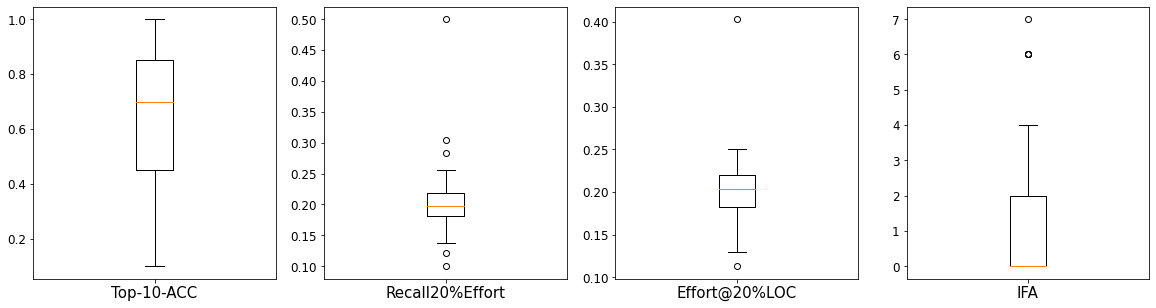

In [9]:
# cur_proj = 'openstack'
plot_result('openstack')